In [1]:
import scipy.io as sio
import os
import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

import seaborn as sns
sns.set(style="whitegrid", palette="muted")

%matplotlib inline 

In [2]:
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
allFiles = os.listdir(path)
treatment = filter(lambda f: 'baz1' in f, allFiles)
treatment = filter(lambda f: os.path.isdir(os.path.join(path, f)), treatment)
treatment

['less_baz1', 'less_baz1ff']

In [3]:
# read data in one position
def read_from_pos(posDir):
    fpath = os.path.join(posDir, 'data.mat')
    if os.path.exists(fpath):
        data = sio.loadmat(fpath)
    else:
        data = {}
    return data

In [4]:
# get subfolders
# 'p\d+' for seleting position folder
# 'dish' for seleting dish folder
def get_sub_folders(dishDir, pattern):
    allFiles = os.listdir(dishDir)
    posFolders = filter(lambda f: os.path.isdir(os.path.join(dishDir, f)), allFiles)
    posFolders = filter(lambda f: bool(re.search(pattern, f)), posFolders)
    return posFolders
    

In [5]:
# reformat data for dish
def reformat_dish(dishDir):
    posFiles = get_sub_folders(dishDir, 'p\d+')
    
    time_ratio = {}
    delta_basal = []
    
    for pos in posFiles:
        posDir = os.path.join(dishDir, pos)
        cur_data = read_from_pos(posDir)
        if cur_data:
            d = [cur_data['data']['time'][0][0][0], cur_data['data']['ratio'][0][0][0]]
            df = pd.DataFrame(data=np.transpose(d), columns=['time', 'ratio'])
            time_ratio[pos] = df
            delta_basal.append(cur_data['data']['delta_ratio'][0][0][0][0])
        else:
            continue
    return time_ratio, delta_basal

## Plot for each method

In [6]:
 def summary_all(path, ratio_mod, ratio_all):
#     path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
    allFiles = os.listdir(path)
    method = filter(lambda f: 'baz1' in f, allFiles)
    method = filter(lambda f: os.path.isdir(os.path.join(path, f)), method)
    print method

    fig_idx = 1
    plt.figure(figsize=(15,15))

    for item in method:
        methodDir = os.path.join(path, item)
        dishFolders = get_sub_folders(methodDir, 'dish')

        for dish in dishFolders:

            dishDir = os.path.join(methodDir, dish)
            time_ratio, delta_basal = reformat_dish(dishDir)

            tmp = [item] * len(delta_basal)
            tmp = [np.array(tmp), delta_basal]

            df1 = pd.DataFrame(data = np.transpose(tmp), columns=['method', 'ratio'])
            ratio_mod = ratio_mod.append(df1,ignore_index=True)

            try:
                ratio_all[item].extend(delta_basal)
                print len(delta_basal)
            except KeyError:
                ratio_all[item] = delta_basal

            # plot for this dish
            plt.subplot(3, 2, fig_idx)
            for pos in time_ratio:
                plt.plot(time_ratio[pos]['time'], time_ratio[pos]['ratio'], color = 'blue')
        fig_idx += 1

    plt.show()

In [9]:
 def summary_all(path, ratio_mod, ratio_all):
    
    allFiles = os.listdir(path)
    method = filter(lambda f: 'baz1' in f, allFiles)
    method = filter(lambda f: os.path.isdir(os.path.join(path, f)), method)

    fig_idx = 1
    
    for item in method:
        methodDir = os.path.join(path, item)
        dishFolders = get_sub_folders(methodDir, 'dish')

        for dish in dishFolders:

            dishDir = os.path.join(methodDir, dish)
            time_ratio, delta_basal = reformat_dish(dishDir)

            tmp = [item] * len(delta_basal)
            tmp = [np.array(tmp), delta_basal]

            df1 = pd.DataFrame(data = np.transpose(tmp), columns=['method', 'ratio'])
            ratio_mod = ratio_mod.append(df1,ignore_index=True)

            try:
                ratio_all[item].extend(delta_basal)
            except KeyError:
                ratio_all[item] = delta_basal

            # plot for this dish
            plt.subplot(3, 2, fig_idx)
            for pos in time_ratio:
                plt.plot(time_ratio[pos]['time'], time_ratio[pos]['ratio'], color = 'blue')
        fig_idx += 1
    return ratio_mod

    

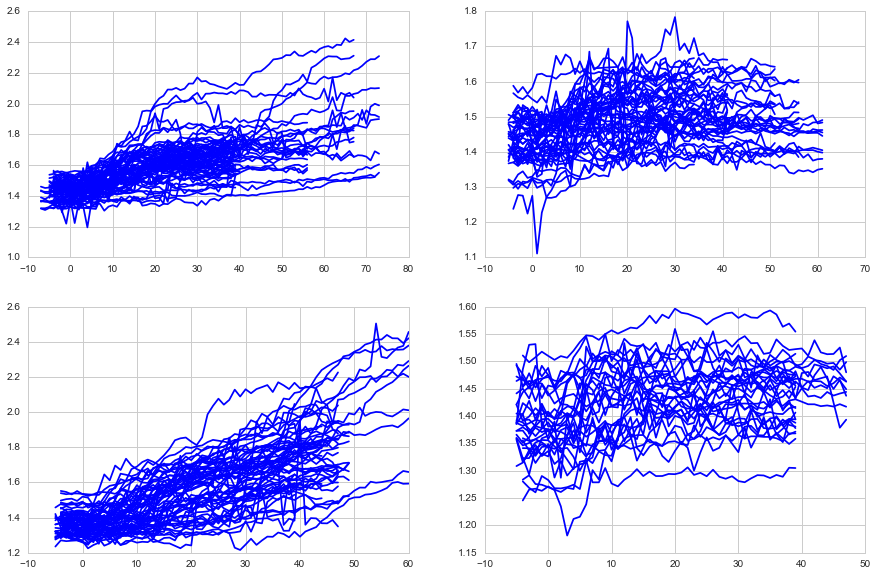

In [10]:
ratio_mod = pd.DataFrame(columns=['method', 'ratio'])
ratio_all = {}

plt.figure(figsize=(15,15))
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0716'
ratio_mod = summary_all(path, ratio_mod, ratio_all)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0820'
ratio_mod = summary_all(path, ratio_mod, ratio_all)
path = r'C:\YiwenShi\pengzhi\bead_binding_0907\0824'
ratio_mod = summary_all(path, ratio_mod, ratio_all)

plt.show()


## Average for each method

In [11]:
ratio_all = pd.DataFrame.from_dict(ratio_all, orient='index')
ratio_all = ratio_all.transpose()
mean_ratio = np.mean(ratio_all)

In [12]:
mean_ratio = np.mean(ratio_all)
print mean_ratio

fl_baz1ff      0.104869
less_baz1      0.349750
less_baz1ff    0.067955
fl_baz1        0.168453
dtype: float64


In [16]:
mean_list = [mean_ratio['less_baz1'], mean_ratio['less_baz1ff'],mean_ratio['fl_baz1'], mean_ratio['fl_baz1ff']]

mean_list

[0.34975006744984283,
 0.067954636538678406,
 0.16845320025193275,
 0.10486908140704422]


## Summary for each method

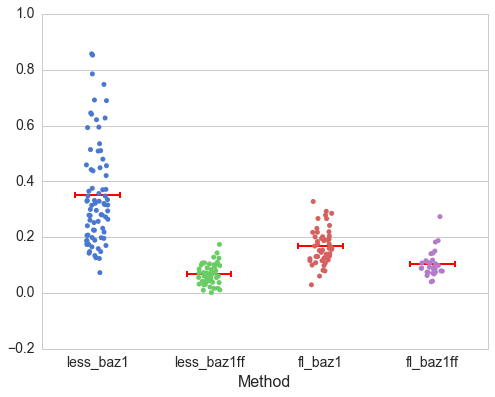

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, frame_on=True)
sns.stripplot(x="method", y="ratio", data=ratio_mod, jitter=True);

linecolor = 'red'
X = range(len(mean_ratio))

plt.errorbar(X, mean_list, xerr = 0.2, linestyle='None',\
             color=linecolor, markersize='10', ecolor=linecolor,zorder=2,linewidth=2,\
             capthick=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(' ', fontsize=16)
plt.xlabel('Method', fontsize=16)

# plt.grid(False)


# # fig.spines['left'].set_position('center')
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(2)

# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('black')
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['top'].set_color('none')

plt.show()

In [18]:
ttest_ind(ratio_all['less_baz1'], ratio_all['fl_baz1ff'])

Ttest_indResult(statistic=nan, pvalue=nan)

In [19]:
ratio_mod.to_csv('0907_data.csv')